In [2]:
import numpy as np
from scipy.sparse.linalg import eigsh, eigs
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
import scienceplots
plt.style.use(['science', 'notebook'])
from scipy import sparse
from skimage import measure
import torch
import plotly.graph_objects as go
from torch import lobpcg
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Create a meshgrid of x and y coordinates

In [16]:
N = 400
X, Y = np.mgrid[0:1:N*1j,0:1:N*1j]

Eigenstates of the Schrodinger equation statisfy $H\psi=E\psi$ where $H$ is the Hamiltonian operator,
and $E$ and $\psi$ represent the eigenvalues/eigenstates. The Hamiltonian Operator in 2D is

$$H = -\frac{1}{2m}(\frac{\partial^2}{\partial x^2}+\frac{\partial^2}{\partial y^2}) + V(x,y)$$

If we discretize $\psi$ into a vector (spacing $\Delta x$), the equation $H\psi = E\psi$ can be arranged and
rewritten in 2 dimensions as

$$[-\frac{1}{2}(D\otimes D)+m\Delta x^2V]\psi = (m \Delta x^2E)\psi$$

where

- $\psi$ is a vector of length $N^2$ where $N$ is the number of discretized points in $x$ and $y$
- $D$ is an $N\times N$ matrix with $-2$ on the main diagonal and $1$ on the two neighboring diagonals.
- $D\otimes D$: the kronexke sum of $D$ with itself so that the derivative matrix is effectively converted to operate on a "2D" vector
- $V$ is a diagonal $N^2\times N^2$ matrix with each entry on the diagonal representative of the potential at that particular coordinate.

Firstly, we define our potential units of $m\Delta x^2$; in other words get_potential actually returns $m\Delta x^2V$

In [17]:
def get_potential(x, y):
    return np.exp(-(x-0.3)**2/(2*0.1**2))*np.exp(-(y-0.3)**2/(2*0.1**2))

V = get_potential(X, Y)

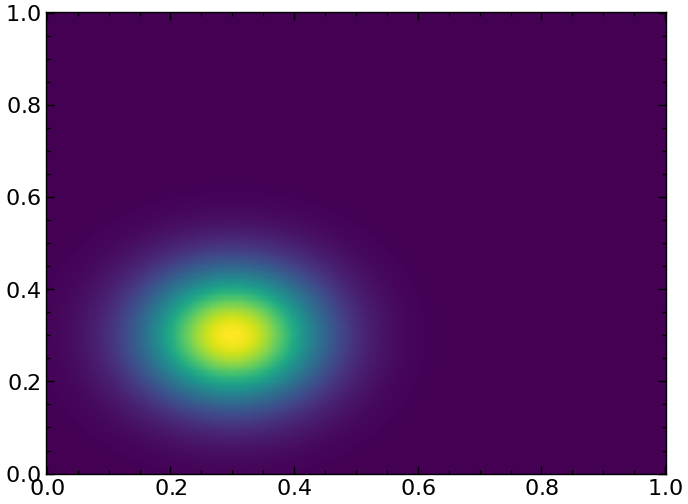

In [18]:
plt.pcolormesh(X,Y,V)

Now we construct
$-\frac{1}{2}D\otimes D +m\Delta x^2V$

Let $T=-\frac{1}{2}D\otimes D$ and $U = m\Delta x^2V$

In [29]:
diag = np.ones([N])
diags = np.array([diag, -2*diag, diag])

D = sparse.spdiags(diags, np.array([-1,0,1]), N,N)
T = -0.5 * sparse.kronsum(D,D)
U = sparse.diags(V.reshape(N**2),(0))
H = T+U

Convert to sparse pytorch tensor

In [30]:
H = H.tocoo()
H = torch.sparse_coo_tensor(indices=torch.tensor([H.row, H.col]),
                            values=torch.tensor(H.data), size=H.shape).to(device)

Compute the eigenvectors and eigenvalues

In [31]:
eigenvalues, eigenvectors = lobpcg(H, k=10, largest=False)

In [35]:
def get_e(n):
    return eigenvectors.T[n].reshape((N,N)).cpu()

(-0.0012531328320802004,
 1.0012531328320802,
 -0.0012531328320802004,
 1.0012531328320802)

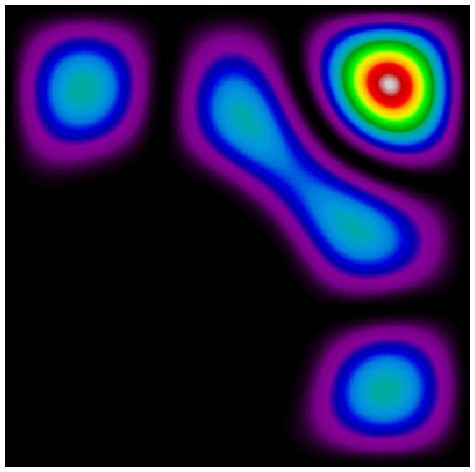

In [47]:
plt.figure(figsize=(6,6))
plt.pcolormesh(X,Y, get_e(4)**2, cmap='nipy_spectral')
plt.axis('off')


# Moving To 3D

The hydrogen atom ptential (choosing $\hbar = 1$) can be expressed as

$$V(r) = -\frac{\exp{2}}{4\piЄ_{0}r}=-\frac{1}{ma_{0}}r$$

and thus

$$m\Delta x^2V=-\frac{\Delta x^2}{a_{0}r}=-\frac{(\Delta / a_{0})^2}{(r/a_{0})}$$
So we'll express $\Delta x$ and $r$ in untits of $a_{0}$

In [93]:
N = 120
X, Y, Z = np.mgrid[-25:25:N*1j, -25:25:N*1j, -25:25:N*1j] # in units of a0, 25 is good
dx = np.diff(X[:,0,0])[0] # in units of a0

Function to get hydrogen wave funktion potential

In [94]:
def get_potential(x,y,z):
    return -dx**2 / np.sqrt(x**2 + y**2 + z**2+ 1e-10)
V = get_potential(X,Y,Z)

Now that we're in 3D, our matrix should be writteen as
$$[-\frac{1}{2}(D⊗D⊗D)+mΔx^2V]\psi = (mΔx^2E)ψ$$

In [95]:
diag = np.ones([N])
diags = np.array([diag, -2*diag, diag])

D = sparse.spdiags(diags, np.array([-1,0,1]),N,N)
T = -0.5 * sparse.kronsum(sparse.kronsum(D,D),D)
U = sparse.diags(V.reshape(N**3), (0))
H = T+U

Convert to PyTorch tensor

In [96]:
H = H.tocoo()
H = torch.sparse_coo_tensor(indices=torch.tensor([H.row, H.col]),
                            values=torch.tensor(H.data), size=H.shape).to(device)

Compute eigenvalues/eigenvectors

In [97]:
eigenvalues, eigenvectors = lobpcg(H, k=20, largest=False)

Function to get eigenvectors:

In [98]:
def get_e(n):
    return eigenvectors.T[n].reshape((N,N,N)).cpu().numpy()

Compute vertices and faces corresponding to iso-surfaces of eigeenfunction so we can show it off in 3D

In [104]:
verts, faces, _, _ = measure.marching_cubes(get_e(4)**2, 1e-6, spacing=(0.1, 0.1,0.1))
intensity = np.linalg.norm(verts, axis = 1)

In [105]:
fig = go.Figure(data=[go.Mesh3d(x=verts[:, 0],y=verts[:, 1], z=verts[:, 2],
                        i=faces[:, 0], j=faces[:, 1], k=faces[:, 2],
                        intensity=intensity,
                        colorscale='Agsunset',
                        opacity=0.5
                                )
                      ]
                )
fig.update_layout(scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)),
        margin=dict(l=0, r=0, b=0, t=0))

fig.show()


Plot the eigenvalue Spectrum:

- The eigenvalues we found are $\mu = mΔx^2E$. First we insert $ħ$ in to make this dimensionless (no longer use the convention $ħ = 1$) so that $\mu = mΔx^2E/ħ^2$.
Then, identifying thet er made $Δx$ in units of $a$, we insert $a$ into the expression so that $ \mu = m(aΔx)^2E/ħ^2$ solving for $E$, 
$$ E = \frac{ħ^2}{mΔx^2a^2}

In [106]:
hbar = 1.055e-34
a = 5.29e-11
m = 9.11e-31
J_to_eV = 6.242e18
conversion = hbar**2 / (m * dx**2 * a**2) * J_to_eV

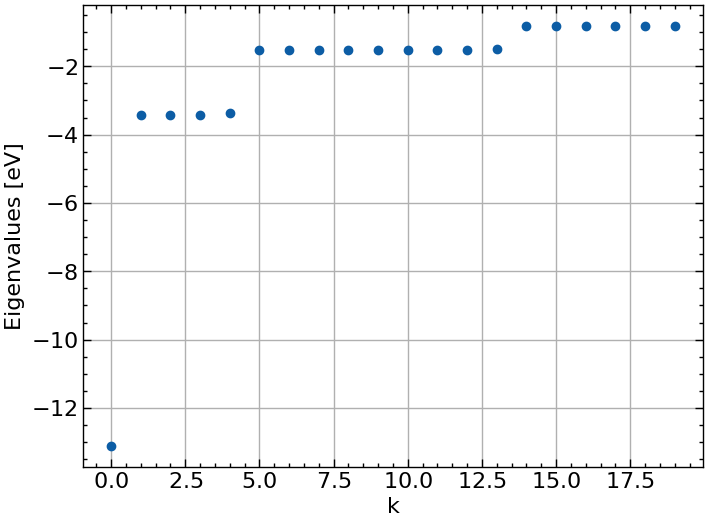

In [107]:
plt.plot(eigenvalues.cpu() * conversion, 'o')
plt.xlabel('k')
plt.ylabel('Eigenvalues [eV]')
plt.grid()

In [108]:
eigenvalues.cpu() * conversion

tensor([-13.1011,  -3.4247,  -3.4247,  -3.4247,  -3.3599,  -1.5176,  -1.5176,
         -1.5176,  -1.5155,  -1.5155,  -1.5155,  -1.5148,  -1.5148,  -1.4953,
         -0.8301,  -0.8155,  -0.8155,  -0.8120,  -0.8076,  -0.8076],
       dtype=torch.float64)